In [3]:
# Learning Practice 6 for the University of Tulsa's QM-7063 Data Mining Course
# Logistic Regression for Classification
# # Professor: Dr. Abdulrashid, Spring 2023
# Noah L. Schrick - 1492657

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

# Problem 10.3

A company that manufactures riding mowers wants to identify the best sales prospects for an intensive sales campaign. In particular, the manufacturer is interested in classifying households as prospective owners or nonowners on the basis of Income (in $1000s) and Lot Size (in 1000 ft2). The marketing expert looked at a random sample of 24 households, given in the file RidingMowers.csv. 

Use all the data to fit a logistic regression of ownership on the two predictors.

a. What percentage of households in the study were owners of a riding mower?  
b. Create a scatter plot of Income vs. Lot Size using color or symbol to distinguish owners from nonowners. From the scatter plot, which class seems to have a higher average income, owners or nonowners?  
c. Among nonowners, what is the percentage of households classified correctly?  
d. To increase the percentage of correctly classified nonowners, should the cutoff probability be increased or decreased?  
e. What are the odds that a household with a $60K income and a lot size of 20,000ft2 is an owner?  
f. What is the classification of a household with a $60K income and a lot size of 20,000 ft2? Use cutoff = 0.5.  
g. What is the minimum income that a household with 16,000 ft2 lot size should have before it is classified as an owner?  

In [11]:
mowers_df = pd.read_csv('RidingMowers.csv')

# a
owner_pctg = mowers_df['Ownership'].value_counts(normalize=True) * 100
print(owner_pctg)


Owner       50.0
Nonowner    50.0
Name: Ownership, dtype: float64


Ownership
Nonowner    57.400
Owner       79.475
Name: Income, dtype: float64


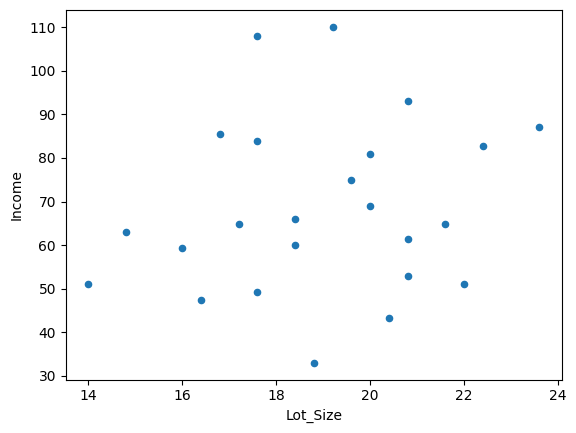

In [12]:
# b 
mowers_df.plot.scatter(x='Lot_Size', y='Income', legend=True)
owner_inc = mowers_df.groupby('Ownership')['Income'].mean()
print(owner_inc)

In [25]:
# c
predictors = ['Lot_Size', 'Income']
outcome = 'Ownership'

X = pd.get_dummies(mowers_df[predictors], drop_first=True)
y = mowers_df[outcome]
classes = ['Owner', 'Nonowner']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.25, 
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

subset_df = full_result.loc[full_result['actual'] == 'Nonowner']

num_corr = 0
total = 0
for index, row in subset_df.iterrows():    
    if (row['actual'] == row['predicted']):
        num_corr += 1
        total += 1
    else:
        total += 1

print("Classified Correctly:", num_corr/total*100.00, "%")
print(subset_df)



Classified Correctly: 80.0 %
      actual      p(0)      p(1) predicted
13  Nonowner  0.418583  0.581417     Owner
14  Nonowner  0.838644  0.161356  Nonowner
17  Nonowner  0.936463  0.063537  Nonowner
18  Nonowner  0.958456  0.041544  Nonowner
20  Nonowner  0.979416  0.020584  Nonowner


# d
Cutoff percentage should be decreased.

In [43]:
# e
data = [[20, 60]]
pred = pd.DataFrame(data, columns=['Lot_Size', 'Income'])

logit_reg_pred_s = logit_full.predict_proba(pred)
p0 = [p[0] for p in logit_reg_pred_s]
p1 = [p[1] for p in logit_reg_pred_s]
full_result = pd.DataFrame({'p(0)': p0,
                            'p(1)': p1,
                            'predicted': logit_full.predict(pred)})
print("Odds of event:", np.exp(p1[0]))


Odds of event: 1.7719334017055501


In [56]:
# f
print(full_result)


Nonowner


In [57]:
# g. What is the minimum income that a household with 16,000 ft2 lot size should have before it is classified as an owner? 
init = 60
while(True):
    data = [[16, init]]
    pred = pd.DataFrame(data, columns=['Lot_Size', 'Income'])

    logit_reg_pred_s = logit_full.predict_proba(pred)
    p0 = [p[0] for p in logit_reg_pred_s]
    p1 = [p[1] for p in logit_reg_pred_s]
    full_result = pd.DataFrame({'p(0)': p0,
                                'p(1)': p1,
                                'predicted': logit_full.predict(pred)})
    if(full_result['predicted'][0] == 'Nonowner'):
        init = init + 0.025
    else:
        print(init)
        break


94.9000000000068


# Problem 10.4

The file eBayAuctions.csv contains information on 1972 auctions transacted on eBay.com during May–June 2004. The goal is to
use these data to build a model that will distinguish competitive auctions from non-competitive ones. A competitive auction is defined as an auction with at least two bids placed on the item being auctioned. The data include variables that describe the item (auction category), the seller (his or her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day of week of auction close). In addition, we have the price at which the auction closed. The goal is to predict whether or not an auction of interest will be competitive.

Data preprocessing. Create dummy variables for the categorical predictors.
These include Category (18 categories), Currency (USD, GBP, Euro), EndDay
(Monday–Sunday), and Duration (1, 3, 5, 7, or 10 days).

a. Create pivot tables for the mean of the binary outcome (Competitive?) as a function of the various categorical variables (use the original variables, not the dummies). Use the information in the tables to reduce the number of dummies that will be used in the model. For example, categories that appear most similar with respect to the distribution of competitive auctions could be combined.  
b. Split the data into training (60%) and validation (40%) datasets. Run a logistic model with all predictors with a cutoff of 0.5.  
c. If we want to predict at the start of an auction whether it will be competitive, we cannot use the information on the closing price. Run a logistic model with all predictors as above, excluding price. How does this model compare to the full model with respect to predictive accuracy?  
d. Interpret the meaning of the coefficient for closing price. Does closing price have a practical significance? Is it statistically significant for predicting competitiveness of auctions? (Use a 10% significance level.)  
e. Use stepwise regression as described in Section 6.4 to find the model with the best fit to the training data (highest accuracy). Which predictors are used?  
f. Use stepwise regression to find the model with the highest accuracy on the validation data. Which predictors are used?  
g. What is the danger of using the best predictive model that you found?  
h. Explain how and why the best-fitting model and the best predictive models are the same or different.  
i. Use regularized logistic regression with L1 penalty on the training data. Compare its selected predictors and classification performance to the best-fitting and best predictive models.  
j. If the major objective is accurate classification, what cutoff value should be used?  
k. Based on these data, what auction settings set by the seller (duration, opening price, ending day, currency) would you recommend as being most likely to lead to a competitive auction.  